In [1]:
'''Tide Calculation using UTide'''
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import tkinter as tk

import utide

text='UTIDE Version = '+utide.__version__
print(text)

UTIDE Version = 0.2.6


In [2]:
def date_parser(year, month, day, hour):
    year, month, day, hour = map(int, (year, month, day, hour))
    return datetime.datetime(year, month, day, hour)


In [3]:
#% input

dt='Maileppet.txt'
lt=-1.563597222
mtd='robust' #'ols'
tzone=7

fl0=dt
slat=lt

# Names of the columns that will be used to make a "datetime" column:
parse_dates = dict(datetime=['year', 'month', 'day','hour'])

'''
Names of the original columns in the file, including only the ones we will use; 
we are skipping the first, which appears to be seconds from the beginning.
'''
names = ['year', 'month', 'day', 'hour', 'elev', 'flag']


In [4]:
#import from txt to dtf format
lat=float(slat)
tzone=int(tzone)
print('method={}'.format(mtd))
from sklearn import metrics
from math import sqrt
UtdF='../data/'+fl0[0:-4]+'.dtf'
fli=open('../data/'+fl0,'r',encoding='cp1252')
flo=open(UtdF,'w')
i=1
for ln in fli:
    if ln[0].isnumeric():
        fl1=ln.split(' ')
        fl2=fl1[0].split('/')
        fl3=fl1[1].split(':')
        rval=float(fl1[2])/100
        cday = '%2d' % int(fl2[0])
        cmonth = '%2d' % int(fl2[1])
        cyear = '%4d' % int(fl2[2])
        chour = '%2d.0000' % int(fl3[0])
        buf = '%6d'% i +' '+cyear+' '+cmonth+' '+cday+' '+chour+' %7.4f' % rval+' 0\n'
        flo.write(buf)
        i=i+1
fli.close()
flo.close()


method=robust


In [5]:

obs = pd.read_table(UtdF,
                    sep=' ',
                    names=names,
                    skipinitialspace=True,
                    #delim_whitespace=True,
                    index_col='datetime',
                    usecols=range(1, 7),
                    na_values='999.999',
                    parse_dates=parse_dates,
                    date_parser=date_parser,
                   )
bad = obs['flag'] == 2
corrected = obs['flag'] == 1

obs.loc[bad, 'elev'] = np.nan
Mobs=obs['elev'].mean()
obs['anomaly'] = obs['elev'] - Mobs

# tide's data interpolation 
obs['anomaly'] = obs['anomaly'].interpolate() + Mobs
print('{} points were flagged "bad" and interpolated'.format(bad.sum()))
print('{} points were flagged "corrected" and left unchanged'.format(corrected.sum()))

#time conversioan to UTC
time = mdates.date2num(obs.index.to_pydatetime())-tzone/24



0 points were flagged "bad" and interpolated
0 points were flagged "corrected" and left unchanged


In [6]:
'''
Definition : solve(t, u, v=None, lat=None, **opts)

Calculate amplitude, phase, confidence intervals of tidal constituents.

Parameters

t: array_like
Time in days since epoch.

u: array_like
Sea-surface height, velocity component, etc.

v: {None, array_like}, optional
If u is a velocity component, v is the orthogonal component.

lat: float, required
Latitude in degrees.

epoch: {string, datetime.date, datetime.datetime}, optional
Valid strings are 'python' (default); 'matlab' if t is an array of Matlab datenums; 
or an arbitrary date in the form 'YYYY-MM-DD'. 
The default corresponds to the Python standard library datetime proleptic Gregorian calendar, 
starting with 1 at 00:00 on January 1 of year 1; this is the 'datenum' used by Matplotlib.

constit: {'auto', array_like}, optional
List of strings with standard letter abbreviations of tidal constituents; 
or 'auto' to let the list be determined based on the time span.

conf_int: {'linear', 'MC', 'none'}, optional
If not 'none' (string), calculate linearized confidence intervals, or use a Monte-Carlo simulation.

method: {'ols', 'robust'}, optional
Solve with ordinary least squares, or with a robust algorithm.

trend: bool, optional
True (default) to include a linear trend in the model.

phase: {'Greenwich', 'linear_time', 'raw'}, optional
Give Greenwich-referenced phase lags, an approximation using linearized times, or raw lags.

nodal: {True, False, 'linear_time'}, optional
True (default) to include nodal/satellite corrections; 
'linear_time' to use the linearized time approximation; 
False to omit nodal corrections.
'''

coef = utide.solve(t=time, u=obs['anomaly'].values,
                   v=None,
                   lat=lat,
                   method=mtd,
                   conf_int='MC')

#print(coef.keys())
tide = utide.reconstruct(time, coef)

solve: matrix prep ... solution ... done.
prep/calcs ... done.


In [7]:
#print(tide.keys())

print('\n')
flo=open('../out/'+UtdF[8:-4]+'_'+mtd+'.coe','w')

ig=len(coef['name'])
print('{:4s} {:^8s} {:^8s}  {:^10s} {:^10s}'.format('Coef','A','A_ci','phase','phase_ci'))
flo.write('{:4s} {:^8s} {:^8s} {:^10s} {:^10s} \n'.format('Coef','A','A_ci','g','g_ci'))
for i in range(ig):
    print('{:4s} {:8.5f} {:8.5f} {:10.5f} {:10.5f}'.format(coef['name'][i],coef['A'][i],coef['A_ci'][i],coef['g'][i],coef['g_ci'][i]))
    flo.write('{:4s} {:8.5f} {:8.5f} {:10.5f} {:10.5f}\n'.format(coef['name'][i],coef['A'][i],coef['A_ci'][i],coef['g'][i],coef['g_ci'][i]))
print('\n\n')
print('Z0= {:6.3f} m'.format(Mobs))



Coef    A       A_ci      phase     phase_ci 
M2    0.37679  0.00108  244.08808    0.16365
S2    0.15066  0.00100  166.60473    0.37933
K1    0.12643  0.00091   72.34536    0.39672
N2    0.08012  0.00126   84.46351    0.91033
O1    0.06737  0.00100  169.94756    0.88417
SSA   0.05441  0.00791  129.49158   10.64312
P1    0.03952  0.00086   66.31339    1.12222
MM    0.03253  0.00799  198.08092   16.08363
K2    0.02891  0.00113  169.74935    2.49960
MSM   0.02737  0.00897   43.74340   20.24305
MF    0.01998  0.00877  254.21726   26.65163
M4    0.01941  0.00139  209.99390    3.86054
NU2   0.01844  0.00109  124.69701    3.52024
MU2   0.01642  0.00113  351.13206    3.79600
Q1    0.01507  0.00099   16.48255    3.00869
2N2   0.01214  0.00104  274.84992    5.42677
MSF   0.01101  0.00896   85.38370   50.01932
L2    0.01091  0.00110   17.45526    5.31153
MS4   0.00964  0.00129  210.77066    7.66567
J1    0.00916  0.00094  192.94570    5.46851
MN4   0.00693  0.00114   29.25317   12.81539
NO1   0

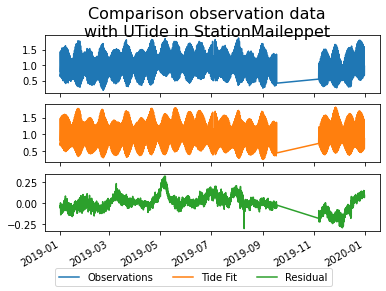

In [8]:
#t = obs.index.values  # dtype is '<M8[ns]' (numpy datetime64)
# It is more efficient to supply the time directly as matplotlib
# datenum floats:

t = tide.t_mpl
res=obs.elev - tide.h
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)
ax0.plot(t, obs.elev, label=u'Observations', color='C0')
ax1.plot(t, tide.h, label=u'Tide Fit', color='C1')
ax2.plot(t, res, label=u'Residual', color='C2')
ax2.xaxis_date()
fig.legend(ncol=3, loc='lower center')
fig.autofmt_xdate()
fig.suptitle('Comparison observation data\nwith UTide in Station' +UtdF[8:-4]+'\n\n', fontsize=16)
fig.savefig('../out/'+UtdF[8:-4]+'_'+mtd+'.png')

In [9]:
print('Std Dev= {:6.3f}'.format(res.std()))

mse=metrics.mean_squared_error(np.array(obs.anomaly) , tide.h)

print('rmse   = {:6.3f}'.format(sqrt(mse)))
print('\n\n')

Std Dev=  0.085
rmse   =  0.085





In [10]:
a=datetime.date(2019,1,1).toordinal()-719163.0
b=datetime.date(2020,1,1).toordinal()-719163.0
times=np.arange(float(a),float(b),1/24)

tides = utide.reconstruct(times, coef)
t = tides.t_mpl

prep/calcs ... done.


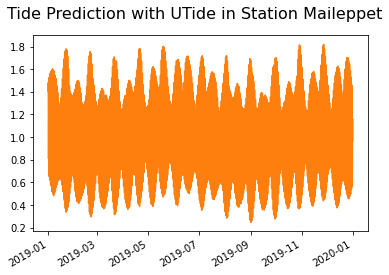

In [11]:
 
fig, (ax0) = plt.subplots(nrows=1, sharey=True, sharex=True)
ax0.plot(t, tides.h, label=u'Tide Prediction', color='C1')
ax0.xaxis_date()
fig.autofmt_xdate()
fig.suptitle('Tide Prediction with UTide in Station ' +UtdF[8:-4], fontsize=16)
fig.savefig('../out/'+UtdF[8:-4]+'_'+mtd+'_P.png')

In [12]:
print('Minimum= {:6.3f} m'.format(obs.elev.min())) 
print('Maximum= {:6.3f} m'.format(obs.elev.max())) 
print('Mean   = {:6.3f} m'.format(Mobs))
print('\n\n')
print('Minimum= {:6.3f} m'.format(tides.h.min())) 
print('Maximum= {:6.3f} m'.format(tides.h.max())) 
print('Mean   = {:6.3f} m\n\n'.format(tides.h.mean()))
print('rmse   = {:6.3f} m'.format(sqrt(mse)))

Minimum=  0.190 m
Maximum=  1.870 m
Mean   =  0.955 m



Minimum=  0.247 m
Maximum=  1.819 m
Mean   =  0.954 m


rmse   =  0.085 m


In [13]:
flo.write('\n\n')
flo.write('Std Dev= {:6.3f}\n'.format(res.std()))
flo.write('rmse   = {:6.3f}\n'.format(sqrt(mse)))
flo.write('\n\n')
flo.write('Minimum= {:6.3f}\n'.format(tide.h.min())) 
flo.write('Maximum= {:6.3f}\n'.format(tide.h.max())) 
flo.write('Mean   = {:6.3f}\n'.format(tide.h.mean()))
flo.write('Minimum= {:6.3f}\n'.format(tides.h.min())) 
flo.write('Maximum= {:6.3f}\n'.format(tides.h.max())) 
flo.write('Mean   = {:6.3f}\n'.format(tides.h.mean()))
flo.close()